## A Model for Sound Classification
In this notebook, I have explored different neural networks to generate a classification between firearm sounds and non firearm sounds. 

In [1]:
from preprocess_train_val import *
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import os
import pandas as pd
import sklearn
import librosa.display

In [2]:
print(DATA_PATH)

../data/train_validate_bal/


First, specify the dimensions of the MFCC spectrogram data. 

Read the data with **save_data_to_array**, and save it to .npy files. 

In [5]:
wandb.init()
config = wandb.config

config.max_len = 170  # the number of "columns" or "time" for the MFCCs 
config.buckets = 20  # the number of MFCCs

# Save data to array file first
save_data_to_array(max_len=config.max_len, n_mfcc=config.buckets)

labels=["firearm_bal", "nonfirearm_bal"]

wandb: Wandb version 0.9.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Saving vectors of label - 'nonfirearm_bal':   0%|          | 0/440 [00:00<?, ?it/s]

The number of labels is:  2


Saving vectors of label - 'firearm_bal':   4%|▍         | 20/451 [00:03<01:27,  4.90it/s]/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
Saving vectors of label - 'firearm_bal':   5%|▌         | 23/451 [00:05<02:09,  3.30it/s]/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
Saving vectors of label - 'firearm_bal':  10%|█         | 47/451 [00:08<00:54,  7.40it/s]/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
Saving vectors of label - 'firearm_bal':  14%|█▎        | 62/451 [00:10<00:51,  7.54it/s]/opt/anacon

Saving vectors of label - 'firearm_bal':  58%|█████▊    | 261/451 [00:44<00:27,  6.99it/s]/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
Saving vectors of label - 'firearm_bal':  60%|██████    | 271/451 [00:46<00:36,  4.99it/s]/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
Saving vectors of label - 'firearm_bal':  63%|██████▎   | 283/451 [00:48<00:36,  4.58it/s]/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
Saving vectors of label - 'firearm_bal':  63%|██████▎   | 284/451 [00:49<00:40,  4.17it/s]/opt/an

* There are 440 files for training and validation pertaining to the **nonfirearm** class
* There are 451 audio files for training/validation belonging to the **firearm** class
* Together, the total sum of data for training/validation amounts to 891 audio files


* 25% of this value will be split into a dataset for validation, that is 268 data files
* The remainder, 75%, will be split into a dataset for training, that is 623 data files

In [6]:
# # Loading train set and validation set
X_train, X_val, y_train, y_val = get_train_validation()

The number of labels is:  2


In [7]:
print(X_train.shape)

(668, 20, 170)


Next, I have specified the number of epochs and the batch size to run a simple neural network. 

In [8]:
# Feature dimension
channels = 1
config.epochs = 50 # hyperparameter
config.batch_size = 100 # hyperparameter

num_classes = 2

X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len, channels)
X_val = X_val.reshape(X_val.shape[0], config.buckets, config.max_len, channels)

wandb: Wandb version 0.9.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [9]:
X_train.shape

(668, 20, 170, 1)

In [10]:
X_val.shape

(223, 20, 170, 1)

In [11]:
y_train.shape

(668,)

Next, the code below identifies the element positions in y_train that correspond to non firearm sounds, that is where `y_train[c]==0.` 

In [12]:
c=0
for element in y_train:
    if element==0:
        print(c)
    c+=1

0
2
4
5
6
7
9
10
11
15
17
18
20
22
25
27
28
29
30
35
36
39
44
47
49
50
52
54
57
58
59
61
62
63
65
69
70
71
72
75
77
79
80
81
82
84
87
88
90
92
93
96
97
98
99
100
104
105
108
109
112
113
114
115
118
119
122
129
132
133
136
137
140
141
142
143
145
146
152
153
154
155
156
157
158
163
167
171
172
174
176
177
178
179
183
184
187
188
190
191
192
193
194
199
202
203
204
208
209
212
213
216
217
219
220
223
224
226
227
229
230
231
235
237
238
240
241
246
247
249
254
255
257
258
259
260
261
262
263
266
267
270
272
274
276
282
283
284
285
286
288
289
291
292
294
296
298
299
303
305
306
307
312
313
315
316
317
318
321
322
324
325
333
335
337
338
340
346
348
349
351
353
354
355
357
362
370
372
376
377
379
380
381
383
384
385
386
388
391
393
395
396
401
403
404
405
410
411
415
417
418
419
422
424
426
427
428
429
430
431
432
433
434
436
438
442
450
453
457
458
462
465
468
470
472
473
476
477
478
479
483
496
497
499
501
503
508
510
516
517
518
520
521
529
532
534
535
536
537
538
540
542
543
544
546
54

Below, I have graphed a representative image of the MFCC spectrogram using the `specshow` attribute in `librosa.display`. 

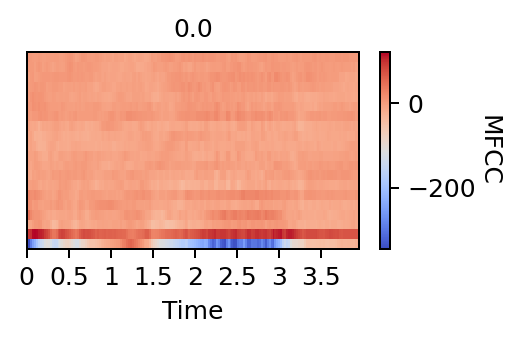

In [13]:
num=0
plt.figure(figsize=(3,2),dpi=180)
librosa.display.specshow(X_train[num, :, :, 0],x_axis='time')
plt.title(str(y_train[num]),fontsize=10)
cbar=plt.colorbar()
cbar.set_label('MFCC',rotation=270,fontsize=10,labelpad=10)
plt.tight_layout()
plt.savefig('../reports/figures/'+'MFCC_'+str(num)+'.png')

The x-axis is time (seconds), the y-axis is the position of a pixel, and the color represents the MFCC according to the colorbar values. 

Next, the y_train values (single vector) are converted to categorical from keras.  That is to mean that there are now two columns, one for each category of firearm sounds, and non-firearm sounds. 

In [14]:
y_train_hot = to_categorical(y_train)
y_val_hot = to_categorical(y_val)

To identify, which category is which, a quick addition of the values in each column can help: 

In [15]:
pd.DataFrame(y_train_hot).sum()

0    326.0
1    342.0
dtype: float32

In [16]:
pd.DataFrame(y_val_hot).sum()

0    114.0
1    109.0
dtype: float32

Here, the nonfirearm sounds correspond to the 0th row.  In the 0th row, values of one indicate nonfirearm sounds. There are 326 non firearm sounds for training, and there are 114 non firearm sounds for validation.  

In the first row, values of one pertain to firearm sounds, and zeros belong to nonfirearm sounds.  There are 342 firearm sounds for training, and there are 109 firearm sounds for validation. 

Next, reshape `X_train` and `X_val` according to the pre-specified spectrogram dimensions. 
Below, I have also built a simple sequential neural network: 
* an input layer
* a hidden layer with activation 'softmax'
* "Adam" optimizer with a specified learning rate

In [17]:
X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len)
X_val = X_val.reshape(X_val.shape[0], config.buckets, config.max_len)

model = Sequential()
model.add(Flatten(input_shape=(config.buckets, config.max_len)))
model.add(Dense(num_classes, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=.05) #optimizer

model.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3400)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 6802      
Total params: 6,802
Trainable params: 6,802
Non-trainable params: 0
_________________________________________________________________


Below, the model is fit to the trainind data and validated with the validation data. 

In [19]:
wandb.init()
history1=model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_val, y_val_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])


wandb: Wandb version 0.9.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/50
21/21 [==============================] - 0s 22ms/step - loss: 717.2950 - accuracy: 0.7320 - val_loss: 234.3728 - val_accuracy: 0.8789
Epoch 2/50
21/21 [==============================] - 0s 8ms/step - loss: 181.6866 - accuracy: 0.8817 - val_loss: 141.5081 - val_accuracy: 0.9103
Epoch 3/50
21/21 [==============================] - 0s 7ms/step - loss: 99.7648 - accuracy: 0.9132 - val_loss: 152.5197 - val_accuracy: 0.9327
Epoch 4/50
21/21 [==============================] - 0s 8ms/step - loss: 95.2301 - accuracy: 0.9162 - val_loss: 164.3213 - val_accuracy: 0.9013
Epoch 5/50
21/21 [==============================] - 0s 9ms/step - loss: 68.4230 - accuracy: 0.9281 - val_loss: 180.0019 - val_accuracy: 0.8700
Epoch 6/50
21/21 [==============================] - 0s 8ms/step - loss: 29.1528 - accuracy: 0.9461 - val_loss: 169.4343 - val_accuracy: 0.8475
Epoch 7/50
21/21 [==============================] - 0s 8ms/step - loss: 54.5589 - accuracy: 0.9296 - val_loss: 158.7165 - val_accuracy: 0.8

wandb: Network error resolved after 0:00:15.168794, resuming normal operation.
wandb: Network error resolved after 0:00:15.266712, resuming normal operation.
wandb: Network error resolved after 0:00:15.469269, resuming normal operation.
wandb: Network error resolved after 0:00:15.625127, resuming normal operation.
wandb: Network error resolved after 0:00:15.995836, resuming normal operation.
wandb: Network error resolved after 0:00:16.335898, resuming normal operation.
wandb: ERROR Error uploading "media/images/examples_30.png": CommError, None
wandb: ERROR Error uploading "media/images/examples_19.png": CommError, None
wandb: ERROR Error uploading "media/images/examples_18.png": CommError, None
wandb: ERROR Error uploading "media/images/examples_31.png": CommError, None
wandb: ERROR Error uploading "media/images/examples_15.png": CommError, File /var/folders/px/t6llprnj0m3fhqqbhbvkrynm0000gn/T/tmpj49qpfuawandb/1j088klf-media/images/examples_15.png size shrank from 69926 to 0 while it 

The results of the fit are visualized below: 

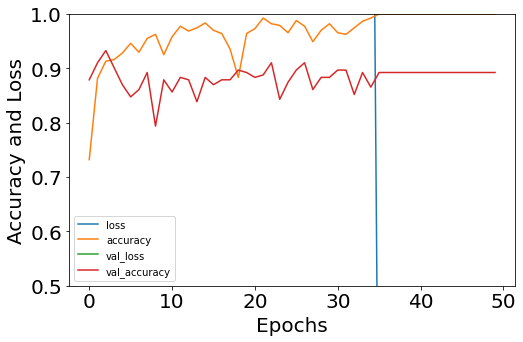

wandb: Network error resolved after 0:00:42.268923, resuming normal operation.
wandb: Network error resolved after 0:00:23.234109, resuming normal operation.
wandb: Network error resolved after 0:00:23.223283, resuming normal operation.
wandb: Network error resolved after 0:00:23.473500, resuming normal operation.
wandb: Network error resolved after 0:00:56.825231, resuming normal operation.
wandb: Network error resolved after 0:00:58.328257, resuming normal operation.
wandb: Network error resolved after 0:00:58.676675, resuming normal operation.
wandb: Network error resolved after 0:01:08.836482, resuming normal operation.
wandb: Network error resolved after 0:01:12.601730, resuming normal operation.
wandb: Network error resolved after 0:01:11.443963, resuming normal operation.
wandb: Network error resolved after 0:01:15.391790, resuming normal operation.
wandb: Network error resolved after 0:01:17.400970, resuming normal operation.
wandb: ERROR Error uploading "config.yaml": CommErro

In [20]:
pd.DataFrame(history1.history).plot(figsize=(8,5),fontsize=20)
# plt.grid(True)
plt.gca().set_ylim(.5,1)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Accuracy and Loss',fontsize=20)
plt.show();

The accuracy approaches 100% after 50 epochs, and the validation accuracy approaches 90%. 

## Test the Sequential NN with some Test Data
Below, I demonstrate this model's ability to detect firearm sounds from non-firearm sounds from the test data. 

In [21]:
from preprocess_test import *

In [22]:
print(DATA_PATH_TEST)

../data/test_bal/


Read the test data and obtain the MFCC spectrogram values for each.  Save to .npy files. 

In [24]:
save_data_to_array(max_len=config.max_len, n_mfcc=config.buckets)
labels=["firearm_test_bal", "nonfirearm_test_bal"]

Saving vectors of label - 'nonfirearm_test_bal':   0%|          | 0/110 [00:00<?, ?it/s]

The number of labels is:  2


Saving vectors of label - 'firearm_test_bal':   1%|          | 1/111 [00:00<00:12,  8.81it/s]/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
Saving vectors of label - 'firearm_test_bal':   5%|▍         | 5/111 [00:00<00:12,  8.39it/s]/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
Saving vectors of label - 'firearm_test_bal':   6%|▋         | 7/111 [00:01<00:16,  6.43it/s]/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
Saving vectors of label - 'firearm_test_bal':  13%|█▎        | 14/111 [00:02<00:16,  5.9

In [25]:
x_non = np.load(labels[1] + '.npy')
print('The number of non firearms',len(x_non))
x_fa= np.load(labels[0] + '.npy')
print('The number of firearms',len(x_fa))

The number of non firearms 110
The number of firearms 111


In [26]:
X_test, X_none, y_test, y_none = get_test()

The number of labels is:  2


In [27]:
print(X_test.shape)
print(y_test.shape)
print(X_none.shape)
print(y_none.shape)

(198, 20, 170)
(198,)
(23, 20, 170)
(23,)


The code above split the data, but below I have recombined it to test on the entire test data set. 

In [28]:
X_test=np.concatenate((X_test,X_none),axis=0)
Y_test=np.concatenate((y_test,y_none),axis=0)
print(X_test.shape)
print(Y_test.shape)

(221, 20, 170)
(221,)


Reshape the test data set. 

In [29]:
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len, channels)
print(X_test.shape)

(221, 20, 170, 1)


Convert to categorical columns. 

In [30]:
Y_test_hot = to_categorical(Y_test)
print(Y_test_hot.shape)

(221, 2)


Similarly as above, I have verified the content of the categorical values:

In [31]:
pd.DataFrame(Y_test_hot).sum()

0    110.0
1    111.0
dtype: float32

This corresponds to the patterns above, where the ones in the 0th row correspond to nonfirearm sounds, and ones in the 1st row correspond to firearm sounds. Thus, there are 110 nonfirearm sounds, and there are 111 firearm sounds. 

Below, I have applied the model to the test data set using `model.evaluate`. 

In [32]:
m_eval=model.evaluate(X_test, np.abs(Y_test_hot))
accuracy=round(m_eval[1]*100,1)
print('\nThe accuracy is:', accuracy,'%')

7/7 [==============================] - 0s 2ms/step - loss: 296.3967 - accuracy: 0.8914

The accuracy is: 89.1 %


Similarly, I can apply the model with `model.predict` to obtain the output predictions from each MFCC spectrogram. 

In [33]:
Y_predict=model.predict(X_test)

In [34]:
pd.DataFrame(Y_predict.round())

,0,1
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0
...,...,...
216,0.0,1.0
217,1.0,0.0
218,0.0,1.0
219,1.0,0.0


How well did it do at predicting? 

In [35]:
pd.DataFrame(Y_predict.round()).sum()

0    108.0
1    113.0
dtype: float32

In [36]:
pd.DataFrame(Y_test_hot).sum()

0    110.0
1    111.0
dtype: float32

It appears that the model miscategorized 10 of the non-firearm sounds as firearm sounds. 

In [37]:
pd.DataFrame(y_train_hot).sum()

0    326.0
1    342.0
dtype: float32

In [38]:
Y_test_hot[:,0:1].sum()

110.0

In [39]:
Y_test_hot[:,1].sum()

111.0

The results will be easier to observe through a confusion matrix: 

In [40]:
import sklearn
conf_mat1=sklearn.metrics.confusion_matrix(pd.DataFrame(Y_test_hot)[1],pd.DataFrame(Y_predict).round()[1])

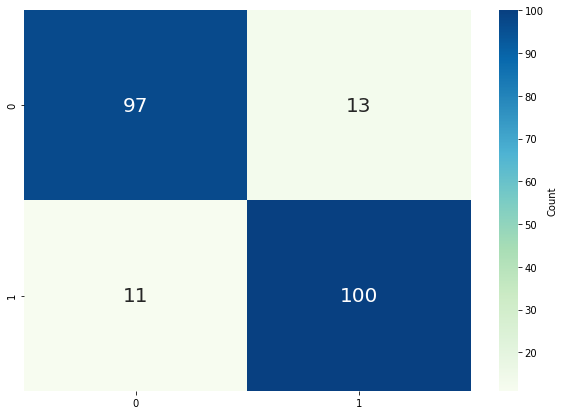

In [41]:
import seaborn as sn 

df_cm = pd.DataFrame(conf_mat1, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,annot_kws={"size": 20},cmap="GnBu",cbar_kws={'label': 'Count'},fmt='d')


* The element, c$_{0,0}$, is equal to 94.  This indicates that there are 94 true negatives.
* The element, c$_{1,0}$, is equal to 6.  This indicates that there are 6 false negatives.
* The element, c$_{0,1}$, is equal to 16.  This indicates that there are 16 false positives. 
* The element, c$_{1,1}$, is equal to 105.  Thus, there are 105 true positives. 

In the context of predicting firearms, the presence of false negatives is grave.  This means that the 6 sounds were actually the sounds of firearms, but it was predicted that they were not. 

Below, I have saved the model. 

In [42]:
# models_path='../models/'
# filename = 'bal_seq_nn_model'+str(accuracy)+'_accuracy.h5'
# nn_model = models_path+filename

# print(nn_model)
# model.save(nn_model)

## Adding Convolution 

Next, I have shown how adding a convolution layer can affect the results of the model. The following draws inspiration from LeNet-5. 

* The learning rate is specified by `alpha`
* The input shape is specified to (20, 170, 1)

The CNN:
* There is a convolusion layer with 8 output filters, a (3,3) kernel_size (height and width of the 2D convolution window), and 'relu' activation. 
* There is a MaxPooling layer with pool_size=(2,2) and strides=2. Thus, the input is downsampled by taking the maximum value over the (2,2) window  for each dimension along the features axis. 
* There is a second convolusion layer with 16 output filters, a (5,5) kernel_size (height and width of the 2D convolution window), and 'relu' activation. 
* There is a MaxPooling layer with pool_size=(2,2) and strides=2. 


* Next, there are two fully connected layers. 
* Last, is the output. 

In [162]:
#input_shape=(batch_size, channels, rows, cols)
alpha=0.0001
# config.epochs = 30 # hyperparameter
input_shape=(20,170,1)

model2 = Sequential()
model2.add(Conv2D(filters=8,
                  kernel_size=(3,3),
                  input_shape=input_shape,
                  activation='relu',
                  padding='valid',
                  data_format='channels_last')
          )
model2.add(MaxPooling2D(pool_size=(2, 2),
                       strides=2)
          )
model2.add(Conv2D(filters=16, 
                  kernel_size=(5, 5), 
                  activation='relu')
          )
model2.add(MaxPooling2D(pool_size=(2, 2),
                        strides=2)
          )
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(units=84, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))

opt2 = keras.optimizers.Adam(learning_rate=alpha)

model2.compile(loss="categorical_crossentropy",
              optimizer=opt2,
              metrics=['accuracy'])

In [163]:
model2.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 18, 168, 8)        80        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 9, 84, 8)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 5, 80, 16)         3216      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 2, 40, 16)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               163968    
_________________________________________________________________
dense_33 (Dense)             (None, 84)              

In [152]:
print(X_train.shape)
print(np.reshape(X_train,(668,20,170,1)).shape)
X_train2=np.reshape(X_train,(668,20,170,1))
print(y_train_hot.shape)
print(X_val.shape)
X_val2=np.reshape(X_val,(223,20,170,1))
print(X_val2.shape)
print(y_val_hot.shape)
print(config.buckets)
print(config.max_len)
print(channels)

(668, 20, 170)
(668, 20, 170, 1)
(668, 2)
(223, 20, 170)
(223, 20, 170, 1)
(223, 2)
20
170
1


Fit this model with convolution to the training and validation data. 

In [164]:
# history2=model2.fit(X_train2, y_train_hot, epochs=epochs.config, validation_data=(X_val2, y_val_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])
history2=model2.fit(X_train2, y_train_hot, epochs=30, validation_data=(X_val2, y_val_hot))#, callbacks=[WandbCallback(data_type="image", labels=labels)])

Epoch 1/30
21/21 [==============================] - 1s 33ms/step - loss: 3.0992 - accuracy: 0.4671 - val_loss: 0.8439 - val_accuracy: 0.7623
Epoch 2/30
21/21 [==============================] - 1s 25ms/step - loss: 0.7747 - accuracy: 0.7874 - val_loss: 0.3814 - val_accuracy: 0.9103
Epoch 3/30
21/21 [==============================] - 0s 20ms/step - loss: 0.4644 - accuracy: 0.8473 - val_loss: 0.2822 - val_accuracy: 0.9058
Epoch 4/30
21/21 [==============================] - 0s 22ms/step - loss: 0.2835 - accuracy: 0.8952 - val_loss: 0.2686 - val_accuracy: 0.9148
Epoch 5/30
21/21 [==============================] - 0s 22ms/step - loss: 0.1850 - accuracy: 0.9401 - val_loss: 0.2113 - val_accuracy: 0.9417
Epoch 6/30
21/21 [==============================] - 0s 21ms/step - loss: 0.1205 - accuracy: 0.9641 - val_loss: 0.2264 - val_accuracy: 0.9283
Epoch 7/30
21/21 [==============================] - 0s 18ms/step - loss: 0.0929 - accuracy: 0.9671 - val_loss: 0.2085 - val_accuracy: 0.9507
Epoch 8/30
21

Evaluate the accuracy of the model to some test data with `model2.evaluation`.

In [165]:
m2_eval=model2.evaluate(X_test, np.abs(Y_test_hot))
accuracy2=round(m2_eval[1]*100,1)
print('\nThe accuracy is:', accuracy2,'%')

7/7 [==============================] - 0s 5ms/step - loss: 0.1041 - accuracy: 0.9593

The accuracy is: 95.9 %


The results of the fit are shown below: 

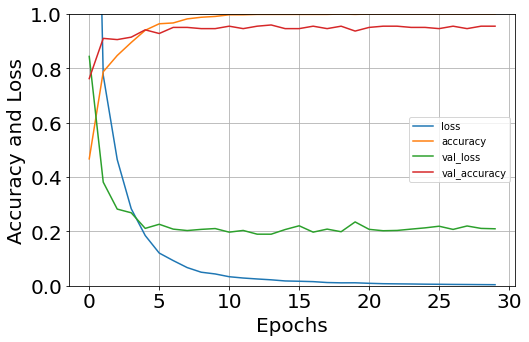

In [166]:
pd.DataFrame(history2.history).plot(figsize=(8,5),fontsize=20)
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Accuracy and Loss',fontsize=20)
plt.show();
# save the figure
# plt.savefig('../reports/CNN_'+'alpha_'+str(alpha)+'_'+str(accuracy2)+'.png')

* The loss function decreases gradually, and plateaus after 20 epochs. 
* The accuracy plateaus to 100% , and the validation accuracy approaches 95%. 

Save the CNN model:

In [ ]:
# models_path='../models/'
# filename = 'bal_cnn_model_accuracy_' +str(accuracy2)+'_alpha_'+str(alpha)+'.h5'
# cnn_model = models_path+filename

# print(cnn_model)
# model2.save(cnn_model)

Next, run a prediction and visualize the results with a confusion matrix: 

In [167]:
Y_predict2=model2.predict(X_test)
# conf_mat2=sklearn.metrics.confusion_matrix(pd.DataFrame(Y_test_hot)[1],pd.DataFrame(Y_predict2).round()[1])

In [168]:
conf_mat2=sklearn.metrics.confusion_matrix(pd.DataFrame(Y_test_hot)[1],pd.DataFrame(Y_predict2).round()[1])

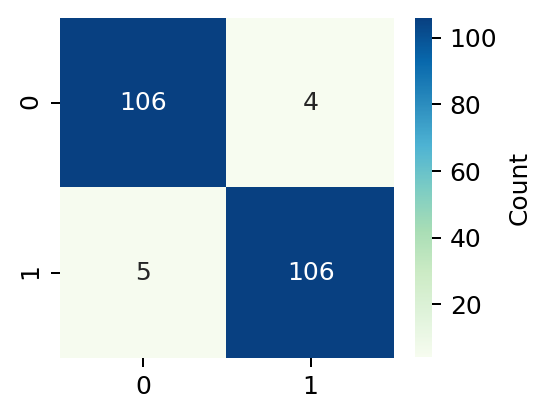

In [169]:
df_cm = pd.DataFrame(conf_mat2, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (3,2.5),dpi=180)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},cmap="GnBu",cbar_kws={'label': 'Count'},fmt='d')
# plt.savefig('../reports/figures/CNN_confusion_mat_'+str(accuracy2)+'_alpha_'+str(alpha)+'.png')


* The element, c$_{0,0}$, is equal to 106.  This indicates that there are 107 true negatives.
* The element, c$_{1,0}$, is equal to 4.  This indicates that there are 4 false negatives.
* The element, c$_{0,1}$, is equal to 5.  This indicates that there are 5 false positives. 
* The element, c$_{1,1}$, is equal to 106.  Thus, there are 106 true positives. 

This model performed significantly better relative to the model without convolution. However, there were still 4 false negatives.  

## Modification to Architecture

* The learning rate is specified by `alpha`
* The input shape is specified to (20, 170, 1)

The CNN is the same as previously described:
* There is a convolusion layer with 8 output filters, a (3,3) kernel_size (height and width of the 2D convolution window), and 'relu' activation. 
* There is a MaxPooling layer with pool_size=(2,2) and strides=2. Thus, the input is downsampled by taking the maximum value over the (2,2) window  for each dimension along the features axis. 
* There is a second convolusion layer with 16 output filters, a (5,5) kernel_size (height and width of the 2D convolution window), and 'relu' activation. 
* There is a MaxPooling layer with pool_size=(2,2) and strides=2. 

Added an additional hidden layer:  

* Finally, there are three fully connected layers. 
* Last, is the output. 

In [219]:
#input_shape=(batch_size, channels, rows, cols)
alpha=0.0001
# config.epochs = 30 # hyperparameter
input_shape=(20,170,1)

model3 = Sequential()
# first convolution and max pooling
model3.add(Conv2D(filters=8,
                  kernel_size=(3,3),
                  input_shape=input_shape,
                  activation='relu',
                  padding='valid',
                  data_format='channels_last')
          )
model3.add(MaxPooling2D(pool_size=(2, 2),
                       strides=2)
          )
# second convolution and max pooling
model3.add(Conv2D(filters=16, 
                  kernel_size=(5,5),
                  activation='relu')
          )
model3.add(MaxPooling2D(pool_size=(2, 2),
                        strides=2)
          )
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(units=64, activation='relu'))
model3.add(Dense(units=32, activation='relu'))
model3.add(Dense(num_classes, activation='softmax'))

opt3 = keras.optimizers.Adam(learning_rate=alpha)

model3.compile(loss="categorical_crossentropy",
              optimizer=opt3,
              metrics=['accuracy'])

In [220]:
model3.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 18, 168, 8)        80        
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 9, 84, 8)          0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 5, 80, 16)         3216      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 2, 40, 16)         0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               163968    
_________________________________________________________________
dense_66 (Dense)             (None, 64)              

In [221]:
history3=model3.fit(X_train2, y_train_hot, epochs=30, validation_data=(X_val2, y_val_hot))

Epoch 1/30
21/21 [==============================] - 1s 39ms/step - loss: 1.7234 - accuracy: 0.5793 - val_loss: 0.4182 - val_accuracy: 0.8610
Epoch 2/30
21/21 [==============================] - 1s 25ms/step - loss: 0.3744 - accuracy: 0.8623 - val_loss: 0.2819 - val_accuracy: 0.8834
Epoch 3/30
21/21 [==============================] - 0s 19ms/step - loss: 0.2501 - accuracy: 0.9012 - val_loss: 0.2802 - val_accuracy: 0.8834
Epoch 4/30
21/21 [==============================] - 0s 18ms/step - loss: 0.2056 - accuracy: 0.9132 - val_loss: 0.2859 - val_accuracy: 0.8700
Epoch 5/30
21/21 [==============================] - 0s 19ms/step - loss: 0.1681 - accuracy: 0.9326 - val_loss: 0.2482 - val_accuracy: 0.8924
Epoch 6/30
21/21 [==============================] - 0s 21ms/step - loss: 0.1491 - accuracy: 0.9446 - val_loss: 0.2169 - val_accuracy: 0.9058
Epoch 7/30
21/21 [==============================] - 0s 20ms/step - loss: 0.1392 - accuracy: 0.9386 - val_loss: 0.2242 - val_accuracy: 0.9103
Epoch 8/30
21

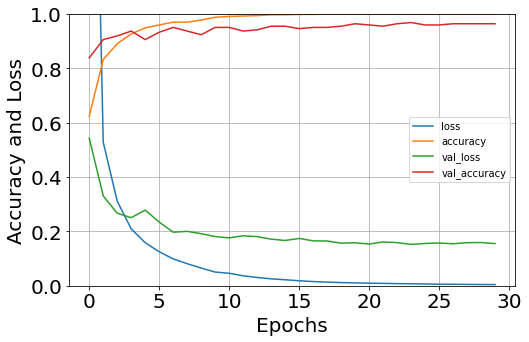

In [216]:
pd.DataFrame(history3.history).plot(figsize=(8,5),fontsize=20)
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Accuracy and Loss',fontsize=20)
plt.show();

The loss of the training data (blue) is lower than that of the the loss of the validation data (green).  This indicates that the model may be overfitting the training data.  

In [217]:
Y_predict3=model3.predict(X_test)
conf_mat3=sklearn.metrics.confusion_matrix(pd.DataFrame(Y_test_hot)[1],pd.DataFrame(Y_predict3).round()[1])

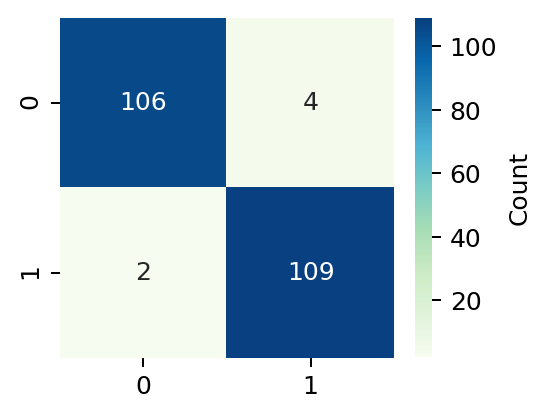

In [218]:
df_cm = pd.DataFrame(conf_mat3, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (3,2.5),dpi=180)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},cmap="GnBu",cbar_kws={'label': 'Count'},fmt='d')
plt.savefig('../reports/figures/CNN_confusion_mat_'+str(accuracy2)+'_alpha_'+str(alpha)+'.png')

## Future work: 
This model can be improved with additional fine tuning of the hyperparameters.  The main hyperparameter that I would like to explore is the inclusion of regularization. 